In [1]:
import os

os.chdir(r'C:\Users\carlo\GitHub\ProjectBuffalo')

In [4]:
import pandas as pd
import numpy as np
import buffalo.algorithm.outliers as ol_algo 

In [16]:
import matplotlib.pyplot as plt

In [9]:
from statsmodels.tsa.api import ArmaProcess
import random

In [6]:
armaprocess = ArmaProcess(ar=np.array([0.75]), ma=np.array([0.23]))

In [12]:
obs = armaprocess.generate_sample(5000)

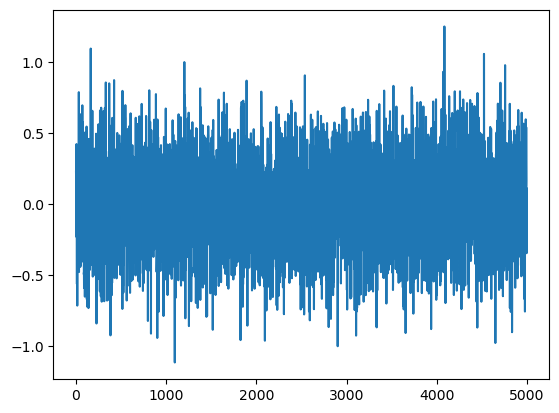

In [17]:
plt.plot(obs)

In [29]:
def add_outliers(obs, ol_info):
    obs = obs.copy()
    added = []
    for i in range(len(ol_info.index)):
        position = np.random.choice(range(len(obs)), ol_info.iloc[i]['Num'])
        effect = np.random.normal(ol_info.iloc[i]['effect_mean'], ol_info.iloc[i]['effect_std'], ol_info.iloc[i]['Num'])
        if ol_info.iloc[i]['type'] == 'AO':
            obs[position] += effect
        added.append(pd.merge(
            pd.DataFrame({'position': position, 'effect': effect}),
            ol_info,
            how='cross'
        ))
    return obs, pd.concat(added, axis=0)

In [30]:
ol_type = pd.DataFrame({
    'type': ['AO'],
    'Num': [100],
    'effect_mean': [20],
    'effect_std': [4]
})

In [31]:
ol_obs, ol_info = add_outliers(obs.copy(), ol_type)

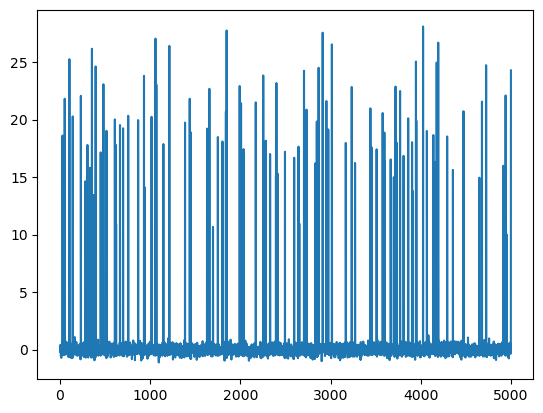

In [33]:
plt.plot(ol_obs)

In [34]:
ol_detection = ol_algo.IterativeTtestOutlierDetection(
    types= pd.DataFrame({'type': ['AO']}),
    maxit=1,
    maxit_iloop=4,
    maxit_oloop=4,
    cval=None,
    cval_reduce=0.14286,
    discard_method='en-masse',
    discard_cval=None,
    tsmethod='ARIMA',
    args_tsmethod={
        "order": (1,0,1),
        "seasonal_order": (0, 0, 0, 0),
        "with_intercept": False
    }
)

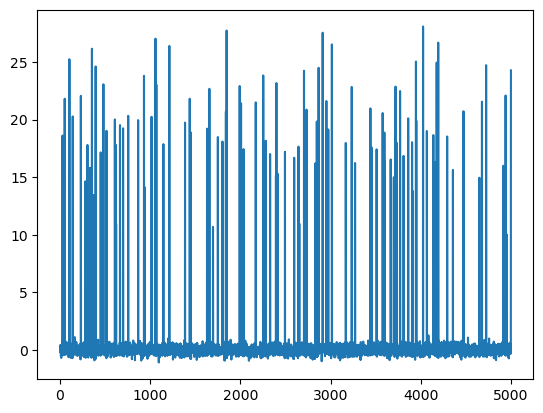

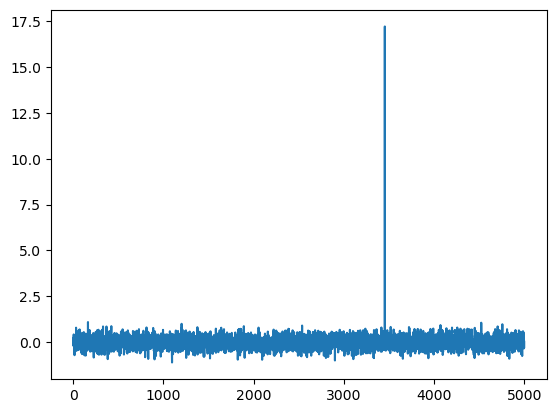

C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\algorithm\outliers.py:632: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  located_ol = located_ol.groupby('type_id').apply(self.remove_consecutive_outliers).reset_index(drop=True)


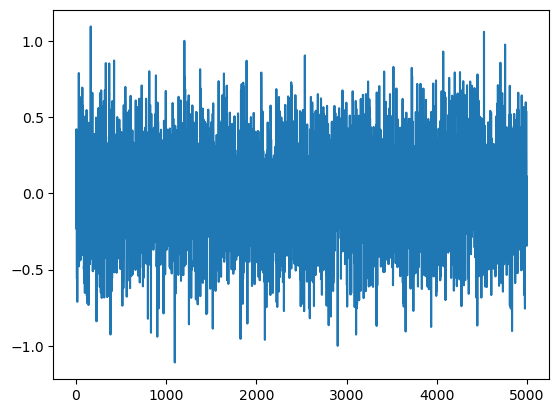

C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\algorithm\outliers.py:632: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  located_ol = located_ol.groupby('type_id').apply(self.remove_consecutive_outliers).reset_index(drop=True)


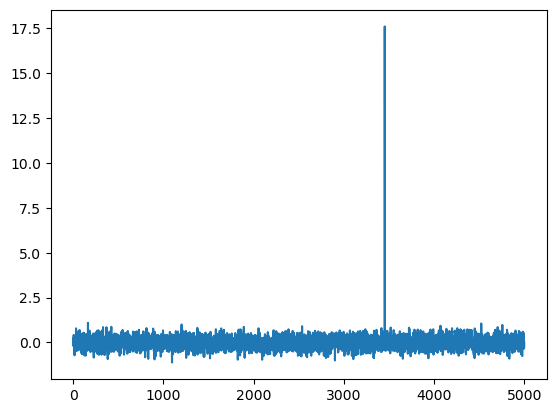

In [37]:
ol_detection.fit(endog=pd.DataFrame(ol_obs)[0], exog=None, fit_args={})